<a href="https://colab.research.google.com/github/SaNcH00PaNzA/GPT/blob/main/PFA_%22Siamese%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing deps

# Installing and Importing Dependencies

In [ ]:
!pip install tensorflow opencv-python matplotlib 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Imports

In [ ]:
#Standard dependencies 
import cv2 
import os 
import random 
import numpy as np
from matplotlib import pyplot as plt 
import uuid 


In [ ]:
#Using tensorflow functional apis 
# Importing dependencies 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D,Dense, MaxPooling2D, Input,Flatten
import tensorflow as tf 
from google.colab.patches import cv2_imshow

# Preparing The Data 

Negative Dataset

In [ ]:
#Downloading the dataset of negative faces
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
#Uncompressing
!tar -xf lfw.tgz 

--2023-04-26 14:14:21--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M   101MB/s    in 1.7s    

2023-04-26 14:14:23 (101 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
# Setup paths 
POS_PATH= os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')
#Building the dir 
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
#Move lfw Images to repositories 
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

**Positive and anchor**

In [ ]:
# Dowloading the positive Images
!wget https://oshi.at/vCyW
# Uncompressing 
!unrar e  vCyW #positive.rar 
# Transfering the dataset to its directory
for file in os.listdir('/content'):
  split_tup = os.path.splitext(file)
  file_extension = split_tup[1]
  if file_extension=='.jpg':
    EX_PATH = os.path.join('/content', file)
    NEW_PATH = os.path.join(POS_PATH, file)
    os.replace(EX_PATH, NEW_PATH)
# Dowloading the anchor Images
!wget  https://oshi.at/Shpg
# Uncompressing
!unrar e  Shpg #anchor.rar
# Transfering the dataset to its directory
for file in os.listdir('/content'):
  split_tup = os.path.splitext(file)
  file_extension = split_tup[1]
  if file_extension=='.jpg':
    EX_PATH = os.path.join('/content', file)
    NEW_PATH = os.path.join(ANC_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

  


--2023-04-26 14:14:26--  https://oshi.at/vCyW
Resolving oshi.at (oshi.at)... 5.253.86.15, 2001:41d0:601:1100::30ad
Connecting to oshi.at (oshi.at)|5.253.86.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1044928 (1020K) [application/octet-stream]
Saving to: ‘vCyW’

vCyW                100%[===================>]   1020K   473KB/s    in 2.2s    

2023-04-26 14:14:39 (473 KB/s) - ‘vCyW’ saved [1044928/1044928]


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from vCyW

Extracting  6604bfbb-d33b-11ed-bebd-fa89d2233583.jpg                       1%  OK 
Extracting  661f7245-d33b-11ed-89bf-fa89d2233583.jpg                       3%  OK 
Extracting  663abe77-d33b-11ed-a487-fa89d2233583.jpg                       5%  OK 
Extracting  66568eb5-d33b-11ed-8ef1-fa89d2233583.jpg                       7%  OK 
Extracting  666e80fd-d33b-11ed-b79f-fa89d2233583.jpg                       9%  OK 
E

# Loading and Preprocessing

**Getting Image Directories** 

In [ ]:
anchor = tf.data.Dataset.list_files('/content/'+ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files('/content/'+POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files('/content/'+NEG_PATH+'/*.jpg').take(300)

In [ ]:
dir_test=anchor.as_numpy_iterator()
print(dir_test.next())

b'/content/data/anchor/897d123f-d33b-11ed-b979-fa89d2233583.jpg'


**Preprocessing**

In [ ]:
def preprocess(file_path): 
    # Read in n load image from file path
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100)) #  The paper says so (105*105)
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

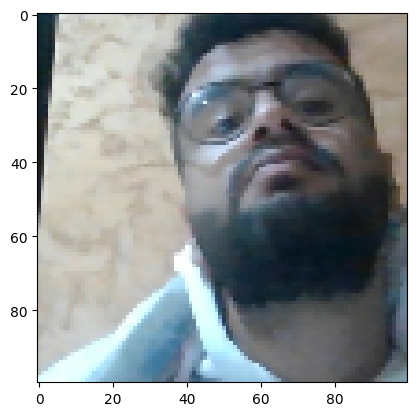

In [ ]:
img=preprocess('/content/data/anchor/64232fb2-d33b-11ed-b0cd-fa89d2233583.jpg')
img.numpy().max()
plt.imshow(img)

**Label The Dataset**



In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) # dataset that has both negative and positive 

In [ ]:
#example of data 
sample=data.as_numpy_iterator()
example=sample.next()
data.as_numpy_iterator().next()

(b'/content/data/anchor/679cc26f-d33b-11ed-aa98-fa89d2233583.jpg',
 b'/content/data/positive/8c7e6a24-d33b-11ed-adf5-fa89d2233583.jpg',
 1.0)

In [ ]:
#preprocess a twin *** return it back to the dataset 
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
#test the preprocess twin *** the astris unpacks the values 
res=preprocess_twin(*example) 

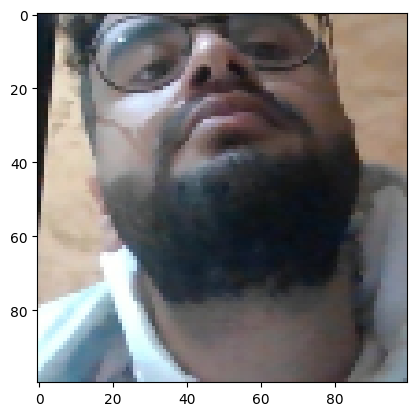

In [ ]:
len(res)
plt.imshow(res[1])

**Building the data Loader Pipeline**

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
sample=data.as_numpy_iterator()
example=sample.next()

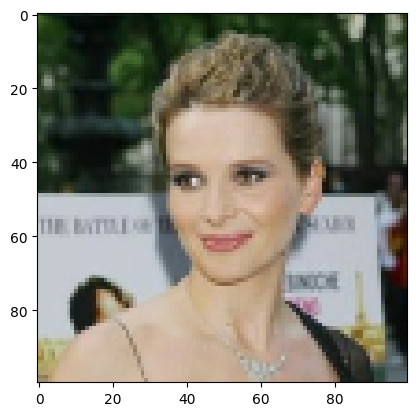

In [ ]:
plt.imshow(example[1])

**Training and testing Data**

In [ ]:
# Training partition 
train_data= data.take(round(len(data)*.7)) # 70% of our data 
train_data=train_data.batch(16)
train_data=train_data.prefetch(8) # to avoid bottle nekcs we need to prefetsh while the latest batch is being fed in 
# Testing partition 
test_data=data.skip(round(len(data)*.7))
test_data= test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
len(train_data.as_numpy_iterator().next()[0]) # batch number

16

# Model Engineering

**Building Preprocessing Layers**

In [ ]:
#Embedding Layer 
'''Transfor the data we r entring into embeddings... 
      The architecture of our model is going to be double streamed working in paralel as they output eventually
      a feature vector of 4096 unit==> transletting our images into a feature vector '''
def make_embedding():
  inp=Input(shape=(100,100,3),name='input_image')
  #First block
  c1=Conv2D(64,(10,10),activation='relu')(inp)
  m1=MaxPooling2D(64,(2,2),padding='same')(c1)
  #Second block
  c2=Conv2D(128,(7,7),activation='relu')(m1)
  m2=MaxPooling2D(64,(2,2),padding='same')(c2)
  #Third block
  c3=Conv2D(128,(4,4),activation='relu')(m2)
  m3=MaxPooling2D(64,(2,2),padding='same')(c3)
  #Final Embedding block
  c4=Conv2D(256,(4,4),activation='relu')(m3)
  f1=Flatten()(c4)
  d1=Dense(4096,activation='sigmoid')(f1)


  return Model(inputs=[inp],outputs=[d1], name='embedding')


In [ ]:
embedding=make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

**Building the distance layer**

In [ ]:
# Distance layer 
'''The L1 distance layer is a custom layer that we will create using a python class '''

class L1Dist(Layer):

  def __init__(self,**kwargs): # allows to work with it in a bigger model helps with import n export 
    super().__init__()           # the kwargs means if we could pass other arguments when we export this to work with it somewhere else 
     
  def call(self,input_embedding,validation_embedding):#input and validation embedding is the result of the two streams woming from our intial layer
    return tf.math.abs(input_embedding - validation_embedding)


**Building the Siamese Model**

In [ ]:
'''input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding=embedding(input_image)
val_embedding=embedding(validation_image)'''

"input_image = Input(name='input_img', shape=(100,100,3))\nvalidation_image = Input(name='validation_img', shape=(100,100,3))\ninp_embedding=embedding(input_image)\nval_embedding=embedding(validation_image)"

In [ ]:
def make_siamese_model():

  #Inputs 
  input_image = Input(name='input_img',shape=(100,100,3))

  #validation
  validation_image=Input(name='validation_img',shape=(100,100,3))

  #combine siamese distance components 
  siamese_layer=L1Dist() 
  siamese_layer._name='distance'
  distances=siamese_layer(embedding(input_image),embedding(validation_image))

  # classifier
  classifier=Dense(1,activation='sigmoid')(distances)
  return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

**Loss and Optimization**

In [ ]:
# Our model has to minimize its loss in order to perform better each time 
# Optimizer helps us perform back propagation through our network
binary_cross_loss=tf.losses.BinaryCrossentropy()
opt=tf.keras.optimizers.Adam(1e-4)

**Diresctories for CheckPoints**

In [ ]:
# if Something goes while training this will help us to go back to a checkpoint and complete from there 
# will be used in the training loop 
checkpoint_dir='training_checkpoints'
os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt') # all chekpts will start with this 
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)



In [ ]:
tst= train_data.as_numpy_iterator()
batch1=tst.next()
print(batch1[2])
X=batch1[:2]
X=np.array(X)
X.shape

[1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0.]


(2, 16, 100, 100, 3)

**Train Step Function**

In [ ]:
# Trainig on a single batsh  
@tf.function # Decorator that compiles a func into a collabale tf graph
def train_step(batch):
  with tf.GradientTape() as tape: # Records what happens inside a neural network
    # get anchor and +or- image   # in order to perform differentiation later on 
    X=batch[:2]
    # get label
    y=batch[2]
    #Forward pass 
    ypred=siamese_model(X,training=True)# training = true activate all the layers 
    #Loss
    loss=binary_cross_loss(y,ypred)
  #Gradients ??
  grad=tape.gradient(loss,siamese_model.trainable_variables)
  #Calc new weights and apply to model 
  opt.apply_gradients(zip(grad,siamese_model.trainable_variables))

  return loss




**Training Loop**

In [ ]:
# Training loop goes through every single epoch and apply our training step 
def train(data,EPOCHS):
  #Loop EPs
  for epoch in range (1,EPOCHS+1):
    print('\n Epoch{}/{}'.format(epoch,EPOCHS))
    progbar=tf.keras.utils.Progbar(len(data))
    #Loop Btchs
    for idx,batch in enumerate(data):
      #Run train step
      train_step(batch)
      progbar.update(idx+1)
    #Save checkpoints 
    if epoch %10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)



**Model training**

In [ ]:
EPOCHS=50
train(train_data,EPOCHS)


 Epoch1/50
5/5 [==============================] - 15s 348ms/step

 Epoch2/50
5/5 [==============================] - 1s 174ms/step

 Epoch3/50
5/5 [==============================] - 1s 174ms/step

 Epoch4/50
5/5 [==============================] - 1s 173ms/step

 Epoch5/50
5/5 [==============================] - 1s 172ms/step

 Epoch6/50
5/5 [==============================] - 1s 172ms/step

 Epoch7/50
5/5 [==============================] - 1s 174ms/step

 Epoch8/50
5/5 [==============================] - 1s 175ms/step

 Epoch9/50
5/5 [==============================] - 1s 174ms/step

 Epoch10/50
5/5 [==============================] - 1s 175ms/step

 Epoch11/50
5/5 [==============================] - 1s 178ms/step

 Epoch12/50
5/5 [==============================] - 1s 176ms/step

 Epoch13/50
5/5 [==============================] - 1s 175ms/step

 Epoch14/50
5/5 [==============================] - 1s 175ms/step

 Epoch15/50
5/5 [==============================] - 1s 175ms/step

 Epoch16/50
5/5 [

## Evaluation


In [ ]:
#import metrics 
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 192ms/step


array([[9.9946457e-01],
       [2.6762097e-08],
       [9.9984872e-01],
       [1.7115036e-08],
       [8.9852424e-11],
       [1.2294366e-12],
       [4.3153809e-04],
       [4.2238435e-09],
       [1.0789733e-07],
       [8.4398835e-08],
       [7.1310952e-10],
       [9.9999988e-01],
       [9.9999952e-01],
       [5.1233854e-08],
       [9.9999106e-01],
       [9.9999666e-01]], dtype=float32)

## Save Model
